In [1]:
# Import packages
from __future__ import division, unicode_literals#, print_function
%matplotlib inline
import numpy as np
from math import radians, sin, cos, floor
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import trackpy as tp
import scipy, pims
from scipy import interpolate, signal
from libtiff import TIFF
from pandas import DataFrame, Series  # for convenience
import cv2

import scipy, xml.etree.ElementTree, tifffile
from datetime import datetime
import metamorph_timestamps

mpl.rc('figure',  figsize=(16, 10))
mpl.rc('image', cmap='gray')


/usr/local/lib/python2.7/site-packages/trackpy/utils.py:46: UserWarning: Due to a bug in Scipy 0.18.0, the (faster) cKDTree cannot be used. For better linking performance, upgrade or downgrade scipy.
  warnings.warn("Due to a bug in Scipy 0.18.0, the (faster) cKDTree cannot "


In [2]:
# Path to tif stack 

# fname = './cropped_spinners_88p65Hz' 
# fname = './good_multi_cell'
fname = './one_switching_spinner'
tifname = fname + '.tif'
meta = metamorph_timestamps.get(tifname)
print meta[-1]
raw_frames = pims.TiffStack(tifname, as_grey=False)
frames = [np.fromstring(f.data, dtype=np.int16) for f in raw_frames] # int16 may have to change depending on dtype
frames = [np.reshape(f, (-1, raw_frames[0].shape[0], raw_frames[0].shape[1]) )[0] for f in frames]

def convert_to_8bit(image):
    # from int32
    im = image.astype(np.float64)
    im2 = (im - im.min())
    im2 = im2*255/im2.max()
    im2 = np.uint8(im2)
    return im2

bit_frames = []
for i in range(len(frames)):
    bit_frames.append(convert_to_8bit(frames[i]))
frames = np.array(bit_frames)

10076.0


In [3]:
def show(image):
    plt.figure()
    plt.imshow(image)
    plt.show()

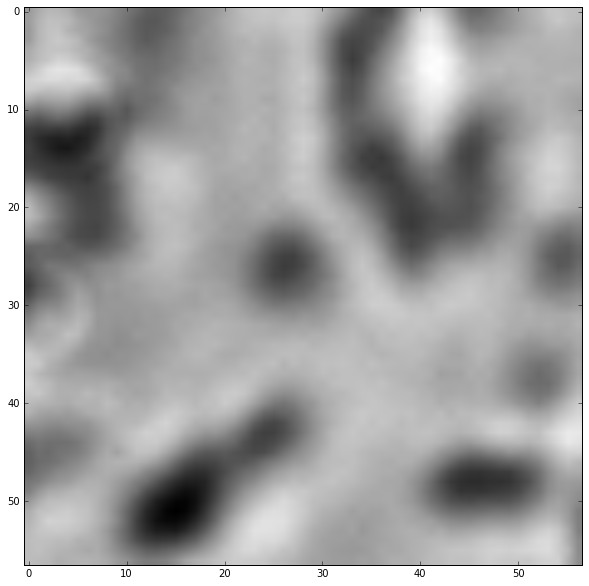

In [4]:
show(frames.mean(axis=0))

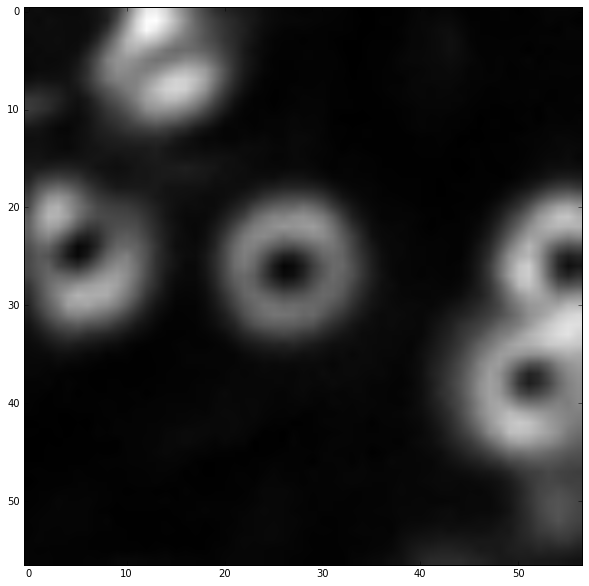

In [5]:
# Compute variance of pixels across all frames
pixel_var = np.var(frames, axis=0)
# avg = pixel_var
show(pixel_var)

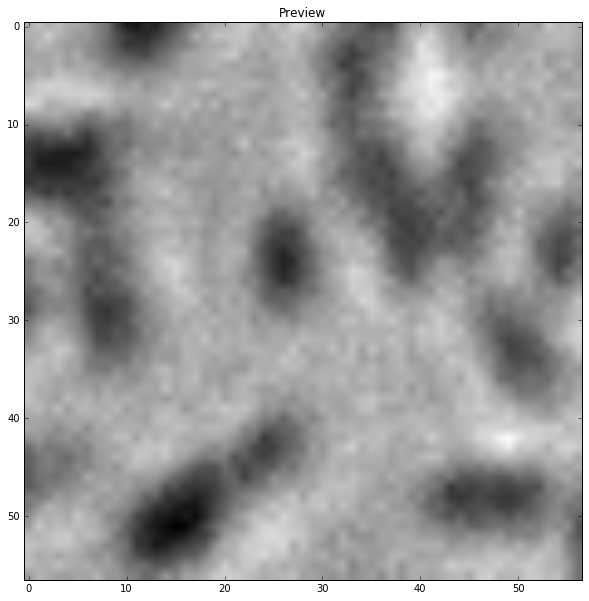

In [6]:
# Preview a frame
preview_image = frames[9]
plt.figure()
plt.title('Preview')
plt.imshow(preview_image)
plt.show()

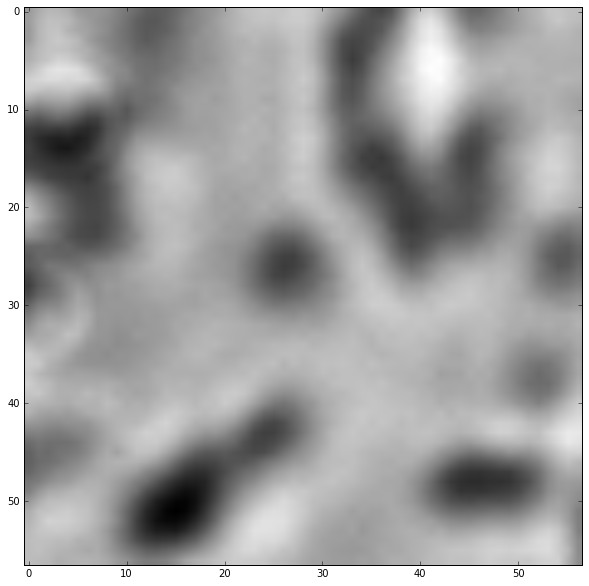

In [7]:
avg = np.mean(frames, axis = 0)
plt.imshow(avg)

Axes(0.125,0.125;0.775x0.775)


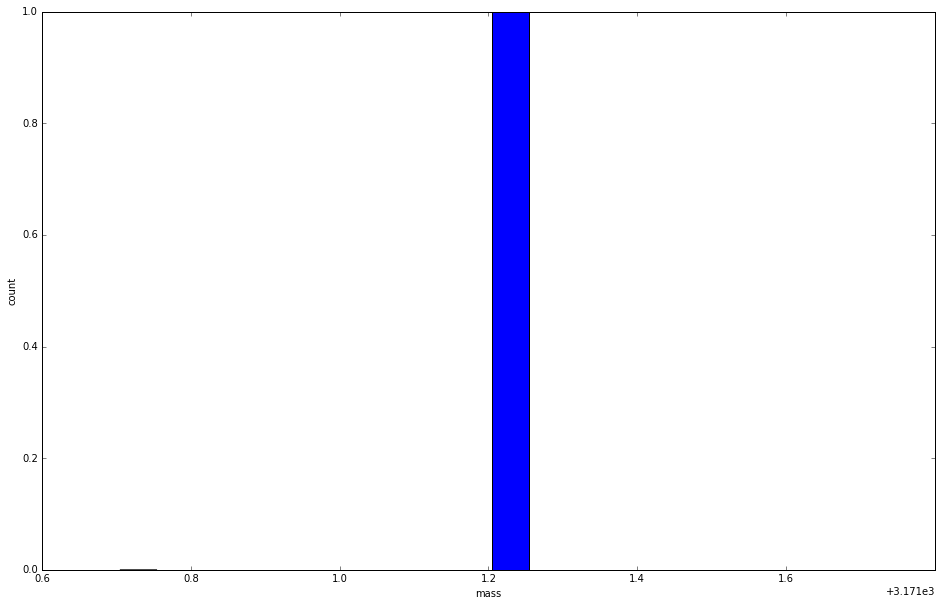

In [10]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)
print ax
# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

In [9]:
f = tp.locate(avg, diameter=13, invert=True) #change 15 later, need to tune
f = f[(f['ecc'] < 0.1)
       ]
f.head() # shows the first few rows of data

,x,y,mass,size,ecc,signal,raw_mass,ep
1,25.88377,26.389943,3172.204553,3.191329,0.031965,75.938049,-13406.1,0.030734


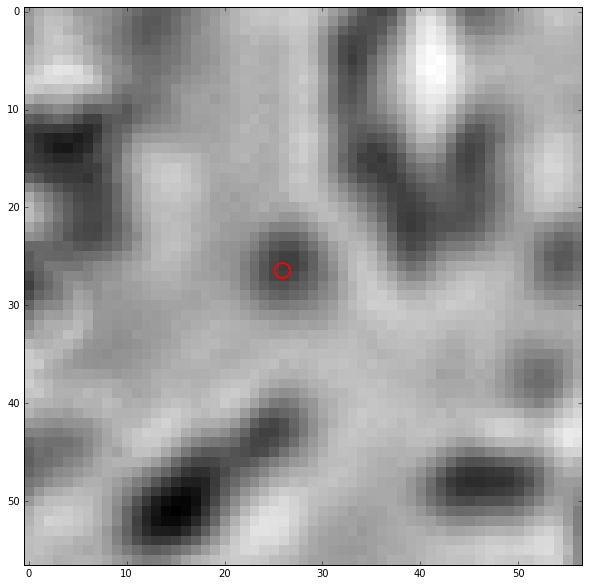

In [48]:
plt.figure()  # make a new figure
tp.annotate(f, avg);
# tp.annotate(f, avg);
#possibly filter particles using ecc vals stationary cells will not look circular

In [49]:
f.x[1]

25.883769948810599

In [50]:
x = f.x[1]
y = f.y[1]
center = [x, y]
radius = 20 #pixel radius

In [51]:
angs=[]
for i in np.linspace(0,360,96): #select num. intervals per circle.
    angs.append(i)

In [52]:
w, l = 2.45, radius #choose dimensions of mask
mymask = np.array([[w,0],[-w,0],[-w,l],[w,l]])

In [53]:
def create_rot_mask(orig_mask, deg):
    rotmymask = []
    ang=radians(deg)
    for i in orig_mask:
        rotMatrix = np.array([[cos(ang), -sin(ang)], [sin(ang),  cos(ang)]])
        rotmymask.append(list(rotMatrix.dot(i)))
    return np.array(rotmymask)

def adj_ctr_mask(mask, deg):
    adj_mask=[]
    for i in create_rot_mask(mask, deg):
        adj_mask.append(list(i+center))
    return np.array(adj_mask)

In [54]:
def angle_kym(ang):
    ang_ar=[]
    
    for i in range(frames.shape[0]):
        
        frame=frames[i].astype(np.uint8)
        
        box=np.int64(adj_ctr_mask(mymask, ang)) #this is the box rotated at ang deg.
        cv2.drawContours(frame,[box],0,(0,0,0),1) 
        
        if i==250 and ang == 0: # shows the windows on top of 75th frame
            plt.figure()
            plt.imshow(frame) #only showing filter do a 360 on first frame.
            plt.show()
        
        mask = np.zeros(frame.shape,np.uint8)
        cv2.drawContours(mask,[box],0,1,-1) # cv2.drawContours(mask,[box],0,255,-1)
        ang_ar.append(cv2.mean(frame,mask=mask)[0])
    
    return ang_ar # for each frame, computes the pixel average for a window rot'd at a given theta 

In [55]:
def invert_colors(kymograph):
    kymograph -= kymograph.min()
    kymograph /= kymograph.max()
    return (1-kymograph) * 255

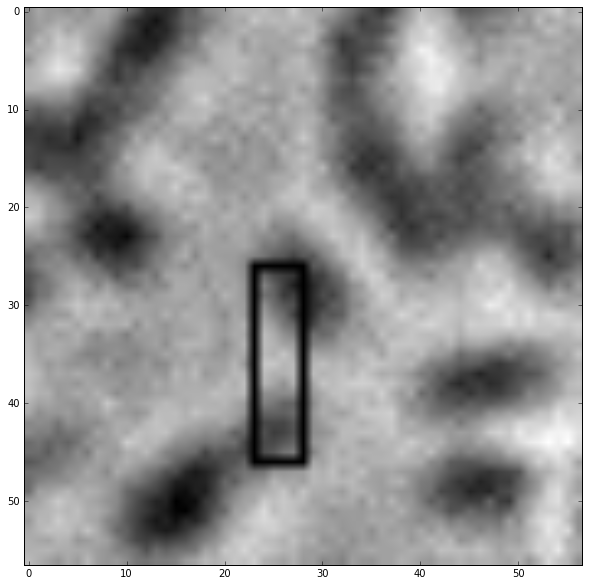

In [56]:
kymograph = []
for ang in angs:
    kymograph.append(angle_kym(ang))

kymograph=np.array(kymograph)
kymograph = invert_colors(kymograph)

In [57]:
print kymograph.shape

(96, 500)


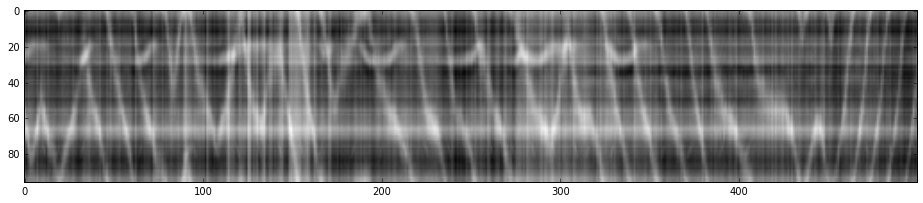

In [58]:
plt.imshow(kymograph)

In [59]:
# plot angular vs time
# delta theta/delta t
# input: video
# output: vel plots per cell

In [60]:
#Remove background by subtracting median of each vertical column from itself.
no_background=[]
orig = np.copy(kymograph)
for i in range(orig.shape[1]):
    #black cells on white background (switch signs if reversed)
    no_background.append(orig[:,i]-np.median(orig,1)) 
no_background=np.array(no_background).T

In [61]:
#Change negative values to 0.
clipped_background = no_background.clip(min=0)
orig = clipped_background

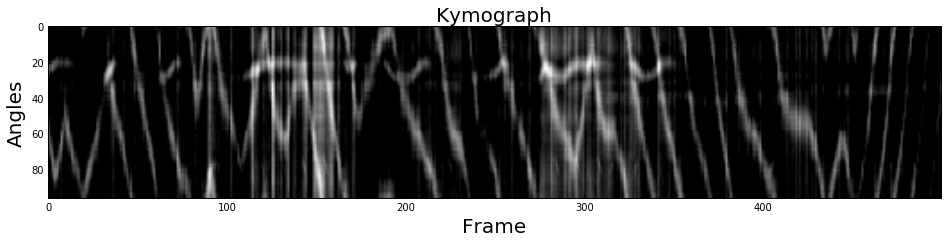

In [62]:
plt.title('Kymograph', fontsize=20)
plt.ylabel('Angles', fontsize=20)
plt.xlabel('Frame', fontsize=20)
plt.imshow(clipped_background)

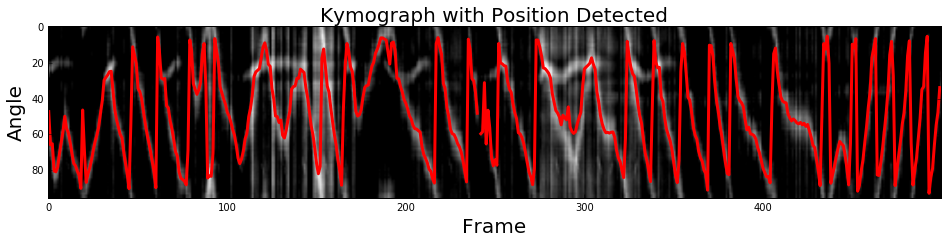

In [63]:
#A weighted sum of the vertical columns, which relates the max intensity in a column to its position.
def exp_func(x):
    return np.dot(np.arange(len(x)), np.power(x, 10))/(np.sum(np.power(x, 10)))

weighted_sum = np.apply_along_axis(exp_func,0, clipped_background)


plt.xlabel('Frame', fontsize=20)
plt.ylabel('Angle', fontsize=20)
plt.title('Kymograph with Position Detected', fontsize=20)
plt.plot(weighted_sum, 'r-', lw = 3)
plt.imshow(clipped_background,cmap='gray')


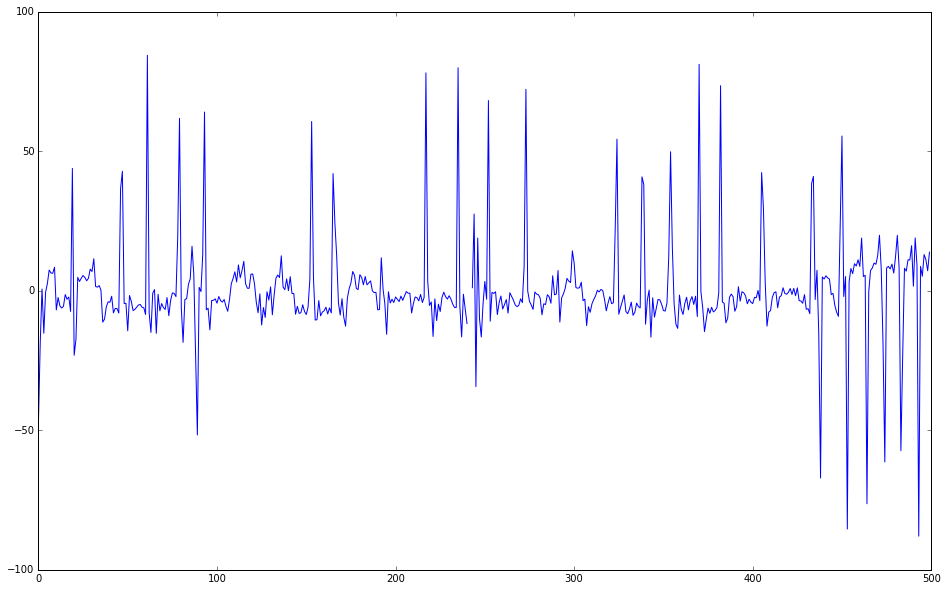

In [139]:
#Derivative of 1D signal. Continuous parts show angular velocity of cell (not 100% sure on this.)
conv = np.convolve([-1.,1],weighted_sum, mode='full')[:-1]
plt.plot(conv)

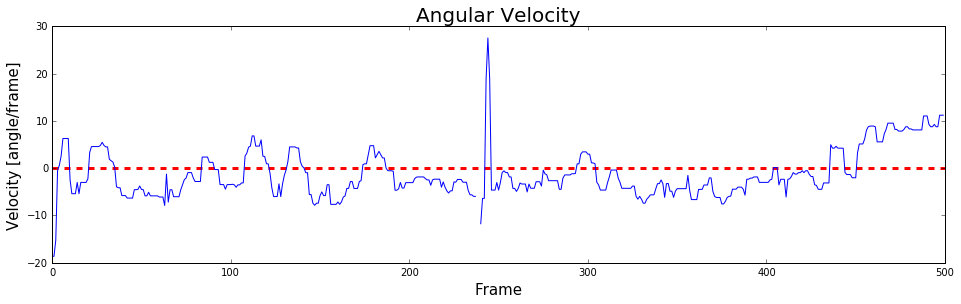

In [140]:
#Derivative of 1D signal. Continuous parts show angular velocity of cell (not 100% sure on this.)
from scipy.ndimage.filters import median_filter
median_filtered_conv = median_filter(conv, 7) #pick window size based on result. second arg and odd number.
plt.figure(figsize=(plt.figaspect(.265))) 
plt.axhline(0, 0, len(median_filtered_conv), linewidth=3, color='r', ls ='--')
plt.plot(median_filtered_conv)
plt.xlabel('Frame', fontsize=15)
plt.ylabel('Velocity [angle/frame]', fontsize=15)
plt.title('Angular Velocity', fontsize=20)

(-1.2, 1.2)

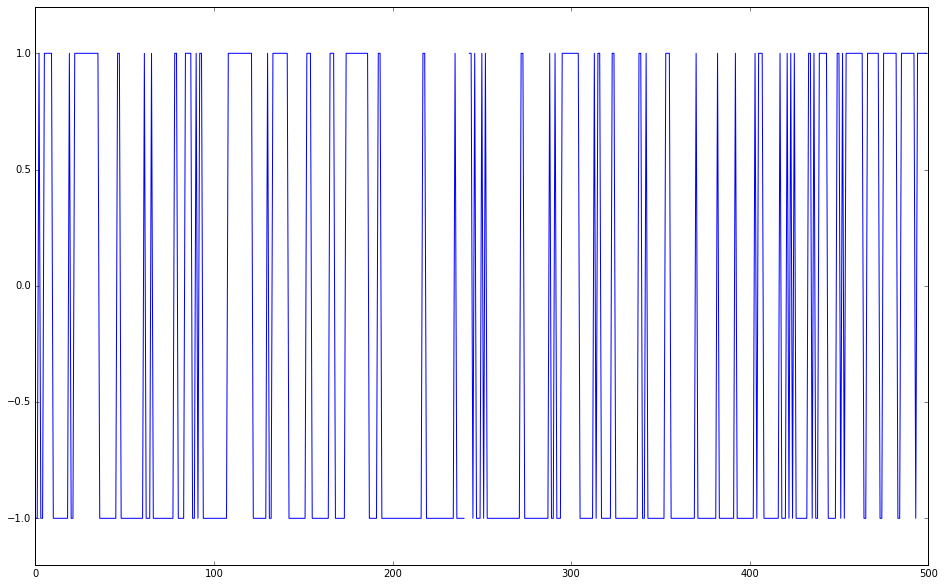

In [141]:
#Tells when the derivative changes sign.
signs=np.sign(conv)
plt.plot(signs)
plt.ylim(-1.2,1.2)

In [142]:
from scipy.ndimage.filters import median_filter


(-1.2, 1.2)

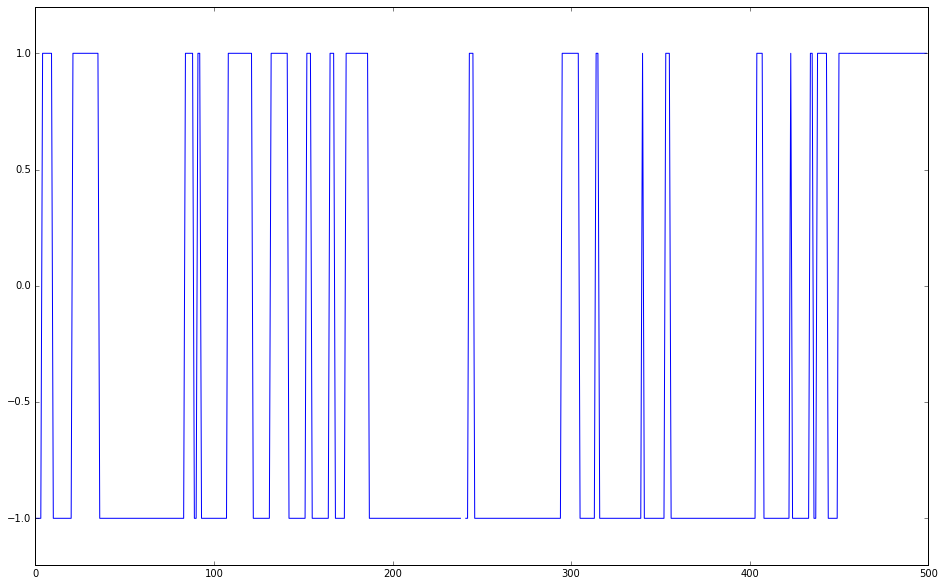

In [143]:
#Applies median filter to above signal.
filtered_signs=median_filter(signs, 5) #pick window size based on result. second arg and odd number.
plt.plot(filtered_signs)
plt.ylim(-1.2,1.2)

In [144]:
#Returns the indices (frame locations) of when the sign switches.
def sign_switch(oneDarray):
    inds=[]
    for ind in range(len(oneDarray)-1):
        if (oneDarray[ind]<0 and oneDarray[ind+1]>0) or (oneDarray[ind]>0 and oneDarray[ind+1]<0):
            inds.append(ind)
    return np.array(inds)

In [145]:
switched_frames = sign_switch(filtered_signs)
switched_frames

#Positive values correspond to cw rotation. Negative = ccw rotation.
cw, ccw=[],[]
for i in range(len(filtered_signs)):
    if filtered_signs[i]<0:
        ccw.append(i)
    if filtered_signs[i]>0:
        cw.append(i)
cw, ccw = np.array(cw), np.array(ccw)

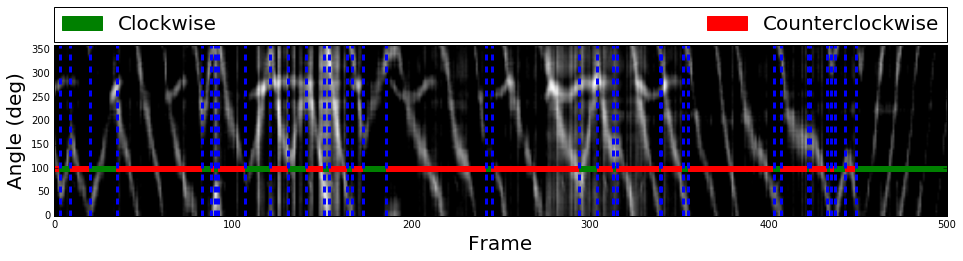

In [146]:
import matplotlib.patches as mpatches
num_frames = orig.shape[1]
#Plot horiz. line s.t. color represents detected dir. of rotation.
sign_colors = ['green' if np.sign(value)==1 else 'red' for value in filtered_signs]
plt.scatter(np.arange(num_frames), np.ones(num_frames)*100, color=sign_colors, marker='s')

red_patch = mpatches.Patch(color='red', label='Counterclockwise')
green_patch = mpatches.Patch(color='green', label='Clockwise')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), handles=[green_patch, red_patch], loc=3, ncol=2, mode="expand", borderaxespad=0, fontsize=20)

#Plot vertical line where switch detected.
for frame in switched_frames:
    plt.axvline(frame, linewidth=3, color='b', ls ='--')

#Show original image in background.
plt.imshow(np.flipud(orig), cmap='gray', extent=(0,orig.shape[1],360,0), aspect='.265')

plt.gca().invert_yaxis()
plt.xlabel('Frame',fontsize=20)
plt.ylabel('Angle (deg)', fontsize=20)
plt.show()

In [147]:
def print_to_csv(input1, title):
    input_list = list(input1)
    with open(title + ".csv", "wb") as csvfile:
        out = csv.writer(csvfile)
        out.writerow(['name','Category'])
        for i in range(0, len(input_list)):
            out.writerow([str(i+1), str(input_list[i])])

In [148]:
def get_date(path_to_tif):
    # Parse timestamp strings from the XML 
    # of the Metamorph metadata.
    # Returns an equivalent numpy array (in miliseconds).
    scope_times = []
    scope_tif_file = tifffile.TiffFile(path_to_tif)
    for t in range(len(scope_tif_file)):
        metadata = scope_tif_file[t].image_description
        root = xml.etree.ElementTree.fromstring(metadata).find('PlaneInfo')        
        for neighbor in root:
            if neighbor.attrib['type'] == 'time':
                if neighbor.attrib['id'] == 'acquisition-time-local':
                    first = neighbor.attrib['value']
                    return first

In [175]:
def print_to_csv(data, fname, names, meta):
    acquisition_time = get_date(tifname)
    with open(fname + ".csv", "wb") as f:
        f.write("Velocity Data," + '\n')
        f.write(tifname + ',\n')
        f.write(acquisition_time + ',\n,\n')
        f.write('time (ms),velocity\n')
        T = len(data[0])
        Cells = len(data)
        for t in range(T):
            new_row_in_file = str(meta[t]) + ','
            for cell_data in range(Cells-1):
                new_row_in_file += (str(data[cell_data][t]) + ',')
            new_row_in_file += (str(data[Cells-1][t]))
            f.write(new_row_in_file + '\n')
    f.close()

In [176]:
print_to_csv([median_filtered_conv], 'test_csv', [tifname], meta)